# AI 4 StoryLines - Baseline LR

In this example, we are going to showcase how we can do sensitivity analysis using a simple linear regression model.

In [10]:
import autoroot
from sklearn.linear_model import LinearRegression, BayesianRidge, ARDRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from pathlib import Path
from dataclasses import dataclass
import xarray as xr
import pandas as pd
import einops
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from bayesevt._src.utils.io import get_list_filenames
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We can see that there is some explained variance that is missing.
Potentially we can explain this with the regression model.

## Load Data

We have a clean analysis-ready dataset available from the previous notebook.
We will save it and revisit it later.

First, we will make sure that the models in the covariates and the QoI are the same.

In [3]:
save_dir = "/pool/usuarios/juanjohn/data/ai4storylines/analysis/"

In [7]:
# load covariates
df = pd.read_csv(Path(save_dir).joinpath("covariates.csv"), index_col=0)
# load qoi
ds = xr.open_dataset(Path(save_dir).joinpath("qoi.nc"))
# quick check
assert df.model.values.sort() == ds.model.values.sort()

## Baseline Model - Linear Regression

#### Input Data

In [25]:
covariate_names = ["sst", "sm_sur", "t2m", "z500_zonal"]
qoi_names = ["tasmax"]
x = df.sort_values(by=["model"])[covariate_names].values
u = ds.sortby("model").tasmax.values

In [27]:
x.shape, u.shape

((28, 4), (28, 19, 21))

We see that we have the `4` covariates and the `19x21` grid points.

Linear Regression only works with a 1D vector. 
So we need to flatten the `u` variable.

In [28]:
x_shape = x.shape
u_shape = u.shape

u_flattened = einops.rearrange(u, "Model Lat Lon -> Model (Lat Lon)")

In [29]:
u_shape, u_flattened.shape

((28, 19, 21), (28, 399))

In [ ]:
u

#### Model

In [45]:
from sklearn import linear_model

reg = linear_model.Ridge(alpha=.1)
reg.fit(x, u_flattened)

Ridge(alpha=0.1)

### Post-Model Analysis

We can extract the parameters for the regression model.
The coefficient corresponds to the slope of the regression model.

In [37]:
reg.coef_.shape, reg.intercept_.shape, reg.alpha,

((399, 4), (399,), 0.1)

We want to plot the coefficient for each of the variables.
First, we need to reshape the 1D Vector to be a `lat-lon` vector.

In [39]:
weights = einops.rearrange(reg.coef_, "(Lat Lon) Variable -> Variable Lat Lon", Lat=u.shape[1], Lon=u.shape[2])

Now, we will add each of these to our dataset so that we can see our

In [83]:
# sea surface height
ds["sst_weights"] = (("lat", "lon"), weights[0])
ds["sst_weights"].attrs["standard_name"] = "Weights"

# soil moisture
ds["sm_weights"] = (("lat", "lon"), weights[1])
ds["sm_weights"].attrs["standard_name"] = "Weights"

# 2m Temperature
ds["t2m_weights"] = (("lat", "lon"), weights[2])
ds["t2m_weights"].attrs["standard_name"] = "Weights"

# Geopotential @ 500
ds["z500_zonal_weights"] = (("lat", "lon"), weights[3])
ds["z500_zonal_weights"].attrs["standard_name"] = "Weights"

## Analysis Dataset

In [84]:
vmin = -2.0
vmax = 2.0

In [85]:
def plot_weights(ds, variable, vmin=None, vmax=None):

    fig = plt.figure()
    fig.set_size_inches(7,5)
    ax = fig.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    cbar_kwargs = {
        "fraction": 0.050, 
        "pad": 0.1, 
        "orientation": "vertical",
    }
    ds.plot.pcolormesh(
        ax=ax, cmap="bwr", vmin=vmin, vmax=vmax, 
        transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs
    )
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.1, color='k', alpha=1, 
                      linestyle='--')
    
    ax.set(title=variable)
    ax.coastlines(linewidth=1)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12} 
    plt.tight_layout()
    plt.show()

    return fig, ax 

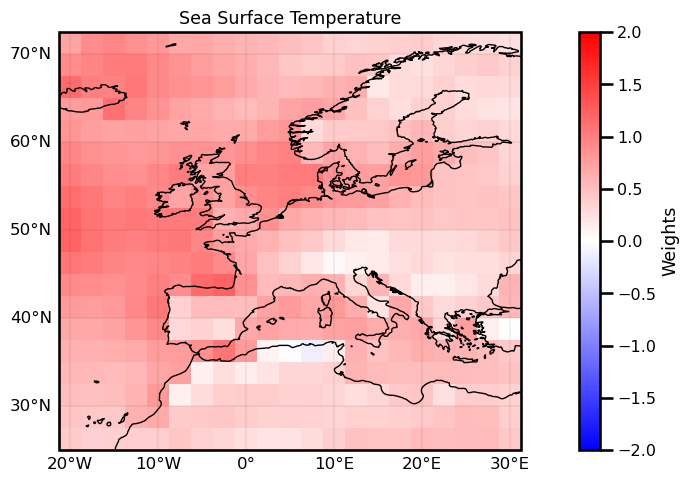

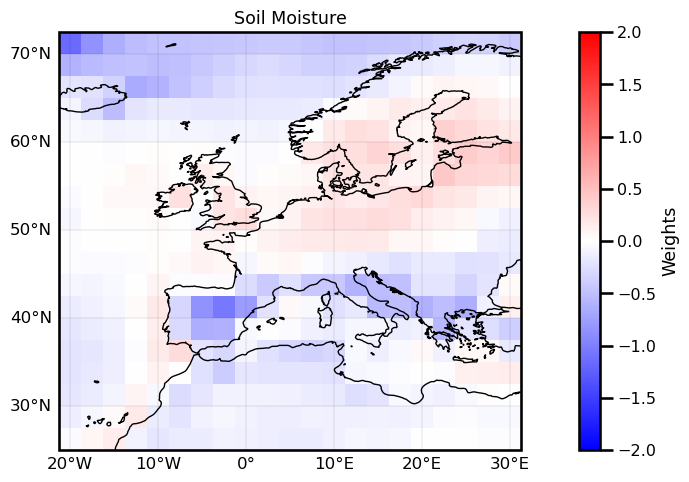

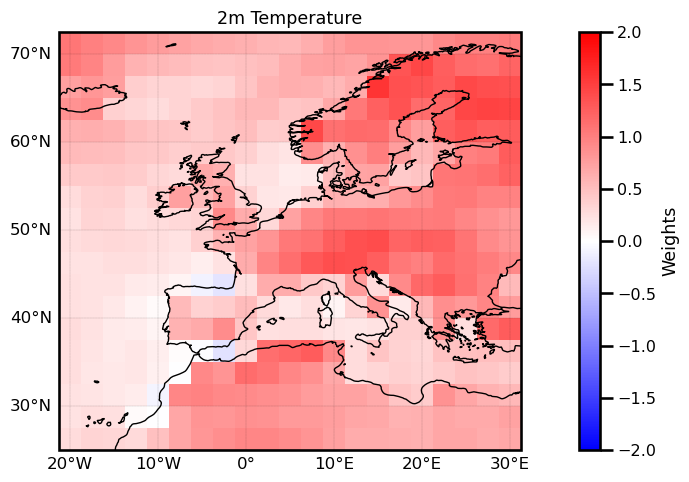

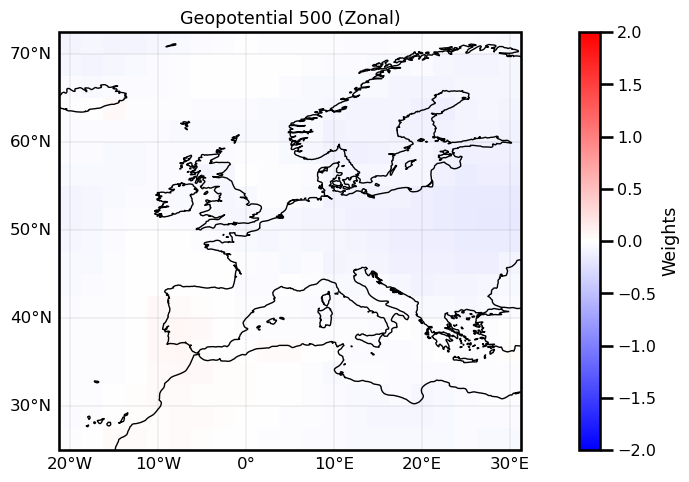

In [87]:
# plot_weights(ds.tasmax.mean(["model"]), "Sea Surface Temperature (Mean)");
plot_weights(ds.sst_weights, "Sea Surface Temperature", vmin=vmin, vmax=vmax);
plot_weights(ds.sm_weights, "Soil Moisture", vmin=vmin, vmax=vmax);
plot_weights(ds.t2m_weights, "2m Temperature", vmin=vmin, vmax=vmax);
plot_weights(ds.z500_zonal_weights, "Geopotential 500 (Zonal)", vmin=vmin, vmax=vmax);

## Things to Do


* Standardize Input/Output Data (see [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing))
* Find the Best Parameters with Cross Validation
* Choose a Better Linear Model ([LASSO](https://scikit-learn.org/stable/modules/linear_model.html#lasso), [LARS](https://scikit-learn.org/stable/modules/linear_model.html#least-angle-regression), [Elastic-Net](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net), [Generalized Linear Model](https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models), [Quantile Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor))